# Practical Assignment 5

Dennis Verheijden, s4455770 and Joost Besseling, s4756799

In [27]:
import numpy as np
from chainer import Chain
from chainer import reporter
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
import matplotlib.pyplot as plt

For the whole assignment we will use the environment as specified below:

In [8]:
class EvidenceEnv(object):
    """
    Very simple task which only requires evaluating present evidence and does not require evidence integration.
    The actor gets a reward when it correctly decides on the ground truth. Ground truth 0/1 determines probabilistically
    the number of 0s or 1s as observations
    """

    def __init__(self, n=1, p=0.8):
        """

        Args:
            n: number of inputs (pieces of evidence)
            p: probability of emitting the right sensation at the input
        """

        self.n_input = n
        self.p = p
        self.n_action = 2

        self._state = None

    def reset(self):
        """
        Resets state and generates new observations

        Returns:
            observation
        """

        # generate state
        self._state = np.random.choice(2)

        return self.observe()

    def step(self, action):
        """
        Executes action, updates state and returns an observation, reward, done (episodic tasks) and optional information

        :param action:
        :return: observation, reward, done, info
        """

        # return 1 for correct decision and -1 for incorrect decision
        reward = (2 * (action == self._state) - 1)

        # generate state
        self._state = np.random.choice(2)

        # we are always done after each decision
        done = True

        return self.observe(), reward, done, None

    def observe(self):
        """
        Helper function which generates an observation based on a state

        :return: observation
        """

        # generate associated observations
        P = [self.p, 1 - self.p] if self._state == 0 else [1 - self.p, self.p]

        return np.random.choice(2, self.n_input, True, P).astype('float32').reshape([1, self.n_input])[0]

    def render(self):
        """
        Takes care of rendering

        :return:
        """

        # print("State: " + str(self._state))

    def close(self):
        """
        Closes the rendering

        :return:
        """
        pass

    def asint(self,obs):
        """
        Represent input observations as an integer number
        :param obs:
        :return:
        """
        return int(sum(2**i*b for i, b in enumerate(obs)))

    def asbinary(self, i, b_len):
        """
        Represent integer as binary array
        :param i: integer
        :param b_len: length of binary array
        :return:
        """

        # get binary representation from integer
        _b = [int(x) for x in list('{0:0b}'.format(i))]
        _b = [0 for _ in range(b_len - len(_b))] + _b

        return _b

    def toBinary(self, obs):
        intValue = self.asint(obs)
        return self.asbinary(intValue, 2)


We invented one function for running a particular agent and plotting the cumulative rewards:

In [9]:
def runAgent():
	# reset environment and agent
	obs = env.reset()
	reward = None
	done = False
	R = []
	cum_R = []
	for step in range(n_iter):
		env.render()
		action = agent.act(obs)
		# print("Action: " + str(action))
		_obs, reward, done, _ = env.step(action)

		# no training involved for random agent
		agent.train(action, obs, reward, _obs)
		obs = _obs
		R.append(reward)

	for r in range(len(R)):
		cum_R.append(sum(R[:r]))

	plt.plot(cum_R)
	plt.xlabel("time")
	plt.ylabel("Cumulative Reward")
	plt.show()

We ran our agents with the following parameters:

In [10]:
# Number of iterations
n_iter = 1000

# environment specs
env = EvidenceEnv(n=2, p=0.75)

### Exercise 1:
For the first exercise we had to run the RandomAgent and plot its cumulative gain:

In [11]:
class RandomAgent(object):
    def __init__(self, env):
        """
        Args:
        env: an environment
        """

        self.env = env

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """

        return np.random.choice(self.env.n_action)

    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """

        pass

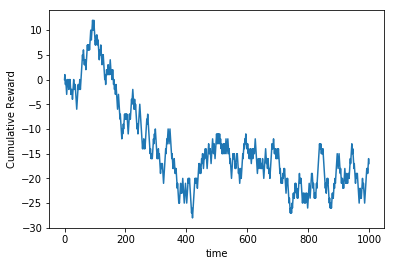

In [13]:
agent = RandomAgent(env)
runAgent()

As we can see and expected, the random agent does not work well.

### Exercise 2:
For the second exercise we had to implement Tabular Q-Learning:

In [14]:
class TabularQAgent(object):
    def __init__(self, env, alpha=0.1, gamma=0.3):
        """
        Args:
            env: an environment
        """

        self.env = env
        self.Q = np.zeros((env.n_action**env.n_input, env.n_action)).astype(np.float32)
        self.alpha = alpha
        self.gamma = gamma

    def act(self, observation):
        """
        Act based on observation and train agent on accumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """
        return 0 if self.Q[self.env.asint(observation), 0] > self.Q[self.env.asint(observation), 1] else 1

    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        old_obs = self.env.asint(old_obs)
        new_obs = self.env.asint(new_obs)

        max_Q = self.Q[new_obs, np.argmax(self.Q[new_obs, :])]

        self.Q[old_obs, a] = (1-self.alpha)*self.Q[old_obs, a] + self.alpha*(r + self.gamma*max_Q)

To plot the Q-values we designed the following function:

In [15]:
def plotQ(Q):
	states = [[0, 0], [0, 1], [1, 0], [1, 1]]
	for state in states:
		for a in [0, 1]:
			print("Q[{},{}]={}".format(state, a, Q[env.asint(state), a]))

The Q-Values before training are:

In [17]:
agent = TabularQAgent(env)
plotQ(agent.Q)

Q[[0, 0],0]=0.0
Q[[0, 0],1]=0.0
Q[[0, 1],0]=0.0
Q[[0, 1],1]=0.0
Q[[1, 0],0]=0.0
Q[[1, 0],1]=0.0
Q[[1, 1],0]=0.0
Q[[1, 1],1]=0.0


Now we run the agent and plot the cumulative reward and the Q-values after training:

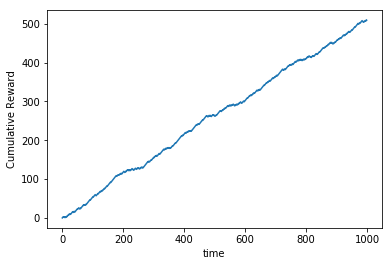

Q[[0, 0],0]=1.2086585760116577
Q[[0, 0],1]=-0.10021000355482101
Q[[0, 1],0]=-0.26689931750297546
Q[[0, 1],1]=0.17511846125125885
Q[[1, 0],0]=0.0794326588511467
Q[[1, 0],1]=-0.1639588475227356
Q[[1, 1],0]=0.0
Q[[1, 1],1]=0.909468412399292


In [18]:
runAgent()
plotQ(agent.Q)

### Exercise 3
Ideally we will want to get rid of the tabular representation because it is (for most real reinforcement learning domains) infeasible to have a Q-value for every possible state. As some might even not be visited because the likelihood of their occurance is low. Also because you would need a lot of occurances to make these Q-values accurate.

For this exercise we use the following network and regressor:

In [19]:
class MLP(Chain):
    """
        Neural Network Definition, Multilayer Perceptron
        l1: fully connected hidden layer
        l2: output layer
    """
    def __init__(self, n_hidden, n_action):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_hidden)   # input layer -> hidden layer
            self.l2 = L.Linear(None, n_action)  # hidden layer -> output layer

    def __call__(self, observation):
        """
        Feed the data in a forward fashion through the MLP
        :param x: Data
        :return: Last Link of the MLP
        """
        layer_hidden = F.relu(self.l1(np.array([observation])))
        layer_output = self.l2(layer_hidden)
        return layer_output

In [20]:
class Regressor(Chain):
	"""
	General implementation of a Regressor class
	"""

	compute_accuracy = False

	def __init__(self, predictor, lossfun, accfun):
		"""
		:param predictor: Chain that predicts output given input; the network
		:param lossfun: loss function
		:param accfun: accuracy function
		"""
		super(Regressor, self).__init__()
		self.lossfun = lossfun
		self.accfun = accfun
		self.y = None
		self.loss = None
		self.accuracy = None

		with self.init_scope():
			self.predictor = predictor

	def __call__(self, x, t):
		self.y = None
		self.loss = None
		self.accuracy = None
		self.y = self.predictor(x)
		self.loss = self.lossfun(self.y, t)
		reporter.report({'loss': self.loss}, self)
		if self.compute_accuracy:
			self.accuracy = self.accfun(self.y, t)
			reporter.report({'accuracy': self.accuracy}, self)
		return self.loss

The agent we used was as follows:

In [21]:
class NeuralAgent(object):
    def __init__(self, env, actualQ):
        """
        Args:
        env: an environment
        """
        n_hidden = 10

        self.MLP = MLP(n_hidden, env.n_action)
        self.model = Regressor(self.MLP, lossfun=self.compute_loss, accfun=None)
        self.env = env
        self.Q = np.zeros((env.n_action ** env.n_input, env.n_action)).astype(np.float32)
        self.actualQ = actualQ

        self.optimizer = optimizers.SGD()
        self.optimizer.setup(self.model)

    def compute_loss(self, y, t):
        """
        We define the loss as the sum of the squared error between the actual and predicted Q values
        :param y: predicted Q-values
        :param t: actual Q-values
        :return: loss
        """
        return sum(np.square(np.subtract(y, t)))

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action
        """
        x = self.model.predictor(observation).data
        action = np.argmax(x)

        return action

    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """

        newQ = self.model.predictor(old_obs).data

        _old_obs = self.env.asint(old_obs)
        self.Q[_old_obs, 0] = newQ[0, 0]
        self.Q[_old_obs, 1] = newQ[0, 1]

        self.optimizer.update(self.model.lossfun, self.Q[_old_obs, :], self.actualQ[_old_obs, :])

For running the agent, we take the Q-values as they were calculated by the TabularQAgent. As before, the Q-values before training are:

In [28]:
actualQ = agent.Q
agent = NeuralAgent(env, actualQ)
plotQ(agent.Q)

Q[[0, 0],0]=0.0
Q[[0, 0],1]=0.0
Q[[0, 1],0]=0.0
Q[[0, 1],1]=0.0
Q[[1, 0],0]=0.0
Q[[1, 0],1]=0.0
Q[[1, 1],0]=0.0
Q[[1, 1],1]=0.0


Running the agent yields the following cumulative reward and Q-Values:

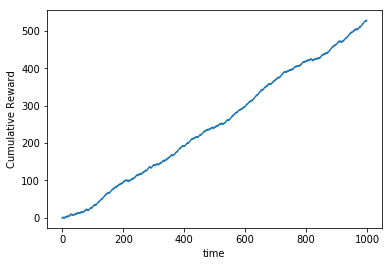

Q[[0, 0],0]=1.1593983173370361
Q[[0, 0],1]=-0.10021000355482101
Q[[0, 1],0]=-0.26689931750297546
Q[[0, 1],1]=0.5461020469665527
Q[[1, 0],0]=0.4309551417827606
Q[[1, 0],1]=-0.2958475947380066
Q[[1, 1],0]=0.0
Q[[1, 1],1]=0.8064603209495544


In [22]:
runAgent()
plotQ(agent.Q)

As we can see, the NeuralQAgent does fairly well, just as the TabularQAgent.

If we would want to deal with past influences we would need to use a Recurrent Neural Network. Where we would reset the states after a game was over.

If we would have continuous actions, rather than discrete actions, we should use a regression class instead of a classification class.